# Diabetic Retinopathy 

La rétinopathie diabétique (Diabetic retinopathy (DR)) est considérée comme l'une des maladies mondiales de la cécité, en particulier chez les personnes âgées. La principale raison de cette maladie est la complication du diabète dans les vaisseaux sanguins rétiniens. Habituellement, les signes avant-coureurs ne sont pas observés. Le dépistage est une clé importante pour le diagnostic des stades précoces de la rétinopathie diabétique. Dans ce travail, notre tâche est de créer un système d'analyse automatisé capable d'attribuer un score basé sur l’échelle suivante : 0 – pas de DR   /1 – léger   / 2 - Modéré   /3 - Sévère /4 - DR proliférative ce qui peut aider les médecins à prendre une décision préliminaire.



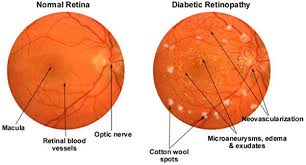

Le diabète, une maladie chronique affecte divers organes du corps humain, y compris la rétine. La rétinopathie diabétique (RD) résulte du diabète sucré (Diabetes Mellitus) (DM). La DM est la principale cause de cécité entre un groupe d'âge significatif dans les pays occidentaux. Il augmente dans les pays sous-développés aussi. Les patients atteints de DM sont beaucoup plus susceptibles à la cécité que sans DM. La rétinopathie diabétique progressive et l'œdème maculaire (cliniquement significatif) peuvent entraîner une perte de vision sévère. La RD affecte une large population diabétique dans les pays développés.
DR, une maladie silencieuse qui n'apparaît qu'à ses derniers stades où le traitement est très difficile et dans certains cas impossibles. Dans la DR les vaisseaux sanguins qui aide à nourrir le la rétine commence à fuir du liquide et du sang sur la rétine, ce qui entraîne des caractéristiques visuelles appelées lésions telles que les microanévrysmes, hémorragies, exsudats durs, taches de coton, région des vaisseaux sanguins. Il ne peut être traité efficacement qu'à ses débuts et donc sa détection précoce est très importante grâce à un dépistage régulier. Le dépistage automatique est hautement nécessaire afin que l'effort manuel soit réduit vu que le cout de cette procédure est assez élevé.


# Dataset:


Les images rétiniennes ont été fournies par EyePACS, une plateforme gratuite de dépistage de la rétinopathie. On dispose d'un grand ensemble d'images rétiniennes haute résolution prises dans diverses conditions d'imagerie. Un champ gauche et droit est fourni pour chaque sujet. Les images sont étiquetées avec un identifiant de sujet ainsi que soit à gauche ou à droite (par exemple, 1_left.jpeg est l'œil gauche du patient id 1). L'ensemble de données comprend 88 696 images de 44 348 sujets, une image pour chaque œil.
 Un clinicien a évalué la présence de rétinopathie diabétique dans chaque image sur une échelle de 0 à 4, selon l'échelle mentionné précédemment.
Les images de cet ensemble de données provenaient de différents modèles et types de caméras et présentaient une qualité très mitigée. Il y avait du bruit dans les images et les étiquettes. Certaines images contenaient des artefacts - étaient floues, sous-exposées ou surexposées. Un objectif majeur de ce projet était de développer un algorithme pouvant fonctionner en présence de bruit et de variations.
échelle:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
# Modéle Utilisé dans ce notebook est ResNet50:


In [1]:
import numpy as np 
import pandas as pd 
import keras
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Flatten, Input 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array
from keras import optimizers
from keras.optimizers import Adam

## Vérification que les images dans notre dataset coresspond avec les images dans notre fichier csv

In [2]:
path = 'C:/Users/HP/Pictures/final-test/'
# Store the image file names in a list as long as they are jpgs
images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.jpeg']
lst = map(lambda each:each.strip(".jpeg"), images)
img = pd.DataFrame(lst,columns =['image']) 
img.head()
img.reset_index(drop=True, inplace=True)

In [3]:
csv_train = pd.read_csv('trainLabels.csv') #lecture des labels
df = pd.merge(csv_train, img, on="image", how='inner')


## Data exploartion

In [5]:
df.values


array([['10_left', 0],
       ['10_right', 0],
       ['13_left', 0],
       ...,
       ['5927_left', 3],
       ['5964_left', 3],
       ['5964_right', 3]], dtype=object)

In [6]:
df.tail()


,image,level
1495,5823_left,3
1496,5823_right,3
1497,5927_left,3
1498,5964_left,3
1499,5964_right,3


In [7]:
df.head(15)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


In [8]:
df.columns

Index(['image', 'level'], dtype='object')

In [9]:
df.isnull().any()


image    False
level    False
dtype: bool

In [10]:
df.isnull().sum().sum()

0

In [172]:
df['level'].value_counts().sum()

35126

In [173]:
df['level'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [13]:
scale = {0 : 'No DR',1 : 'Mild',2 : 'Moderate',3 : 'Severe',4 :'Proliferative DR'}

In [174]:
dr2=df.level.copy()

In [180]:
dr2 = [scale[item] for item in dr2] 

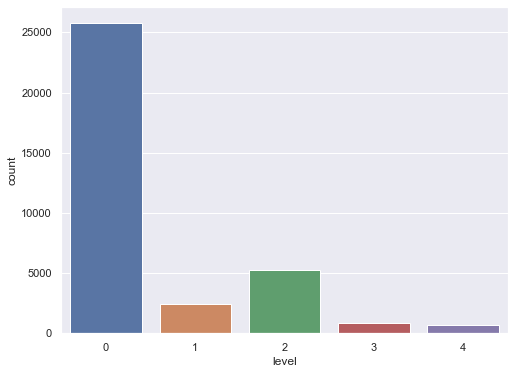

In [186]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="level", data=df)

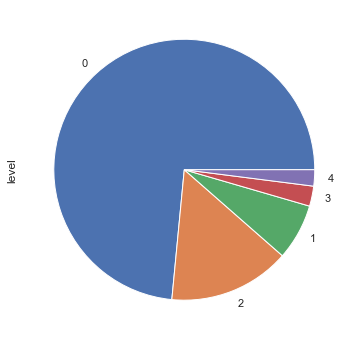

In [185]:
csv_train["level"].value_counts(normalize=True).plot(kind='pie')


In [18]:
targets_series = pd.Series(df['level']) #transformation du columns level en one-hot encoding vectors


In [19]:
targets_series[:10]


0    0
1    0
2    0
3    0
4    1
5    2
6    4
7    4
8    0
9    1
Name: level, dtype: int64

In [20]:
one_hot_labelsY = np.asarray(targets_series) #transformation des target_series à un tabelau


In [21]:
one_hot_labelsY[:100]


array([0, 0, 0, 0, 1, 2, 4, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [22]:
x_train = []
y_train = []

## chargement des images et leur tranformations vers des tableux

In [ ]:
i=0
for f, breed in tqdm(df.values):
    try:
        img = image.load_img(('C:/Users/HP/Pictures/final-test/{}.jpeg'.format(f)), target_size=(256,256))
        arr = image.img_to_array(img)
        label = one_hot_labelsY[i]
        x_train.append(arr)
        y_train.append(label)
        i += 1 
    except:
        pass

In [ ]:
np.save('x_train35',x_train)
np.save('y_train35',y_train)

In [ ]:
x_train = np.load('x_train2.npy')
y_train = np.load('y_train2.npy')

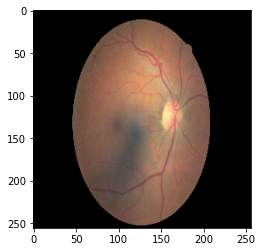

In [26]:
plt.imshow(x_train[15]/255)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


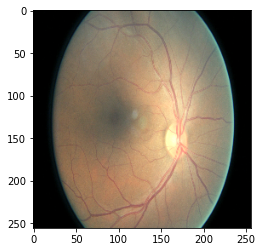

In [27]:
plt.imshow(x_train[162]/230)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


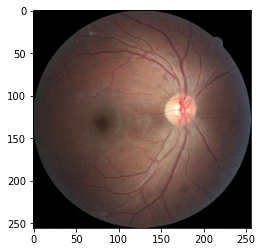

In [28]:
plt.imshow(x_train[300]/190)
plt.show()

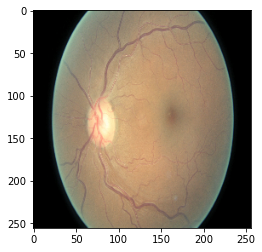

In [29]:
plt.imshow(x_train[99]/255)
plt.show()

## Division du dataset ----->train[70/100] -------->test[30/100]

In [30]:
x_valid = []
y_valid = []
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=1)

In [31]:
y_train_raw = np.array(Y_train)


In [32]:
x_train_raw = np.array(X_train)


In [33]:
print(x_train_raw.shape)
print(y_train_raw.shape)


(1049, 256, 256, 3)
(1049,)


In [34]:
num_class = y_train_raw.shape[0]


## Modele Resnet50

In [35]:
from keras.applications.resnet50 import ResNet50


In [36]:
base_model = ResNet50(weights = None, include_top=False, input_shape=(256,256, 3))

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(5, activation='multi:softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [37]:
x_valid_raw = np.array(X_valid)
y_valid_raw = np.array(Y_valid)

In [38]:
history = model.fit(x_train_raw,y_train_raw, epochs=5,validation_data=(x_valid_raw,y_valid_raw),verbose=1)


Epoch 1/5
33/33 [==============================] - 1271s 38s/step - loss: 12.0532 - accuracy: 0.4529 - val_loss: 1.5769 - val_accuracy: 0.6978
Epoch 2/5
33/33 [==============================] - 1171s 35s/step - loss: 1.5696 - accuracy: 0.6977 - val_loss: 1.5472 - val_accuracy: 0.6978
Epoch 3/5
33/33 [==============================] - 1031s 31s/step - loss: 1.5404 - accuracy: 0.6923 - val_loss: 1.5177 - val_accuracy: 0.6978
Epoch 4/5
33/33 [==============================] - 908s 28s/step - loss: 1.5102 - accuracy: 0.6991 - val_loss: 1.4893 - val_accuracy: 0.6978
Epoch 5/5
33/33 [==============================] - 936s 28s/step - loss: 1.4902 - accuracy: 0.6650 - val_loss: 1.4611 - val_accuracy: 0.6978


In [40]:
test_loss, test_acc = model.evaluate(x_valid_raw, y_valid_raw)


15/15 [==============================] - 58s 4s/step - loss: 1.4611 - accuracy: 0.6978


In [41]:
test_loss


1.4611196517944336

In [42]:
test_acc

0.6977777481079102

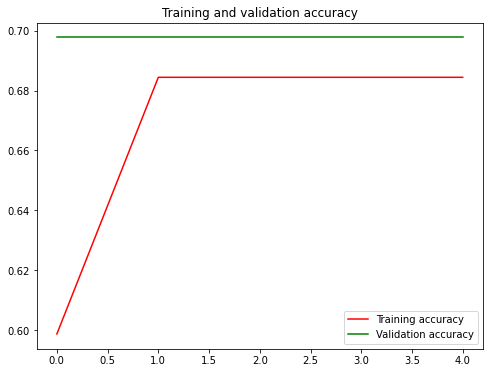

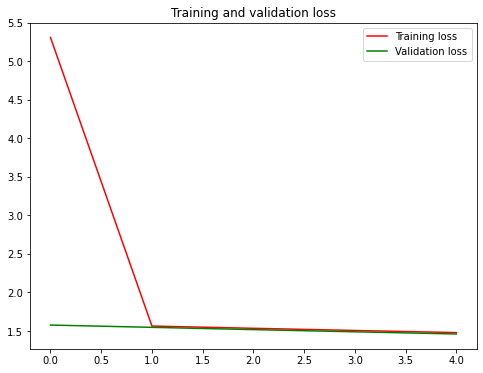

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(x_valid_raw)


In [45]:
y_pred = np.argmax(np.round(y_pred),axis=1)


## true prediction

 labels correct


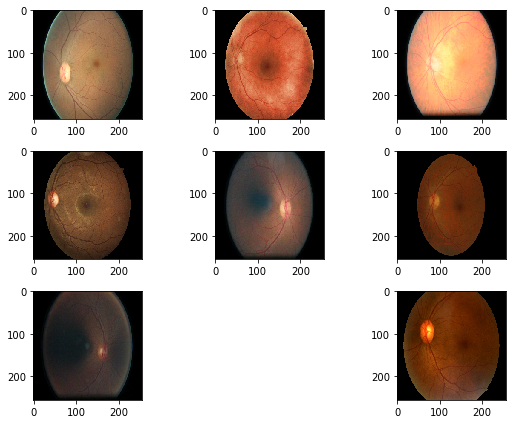

In [148]:
correct = np.where(y_pred==y_valid_raw)[0]
print(" labels correct")
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_valid[correct]/255, cmap='gray', interpolation='none')
    plt.tight_layout()

## false prediction

prédiction fausse


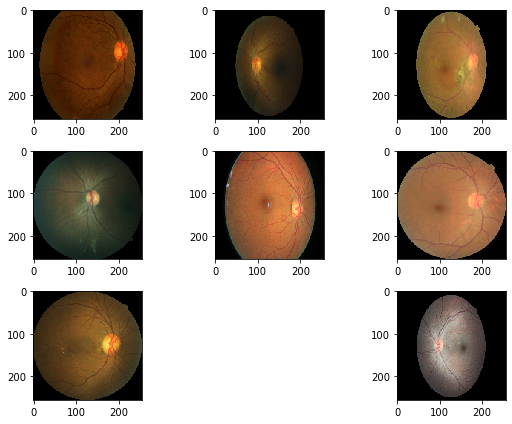

In [109]:
incorrect = np.where(y_pred!=y_valid_raw)[0]
print ("prédiction fausse")
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_valid[incorrect]/255, cmap='gray', interpolation='none')
    plt.tight_layout()

## Matrice de confusion

In [50]:
from sklearn.metrics import confusion_matrix


In [51]:
matrice =confusion_matrix(y_pred,y_valid_raw)


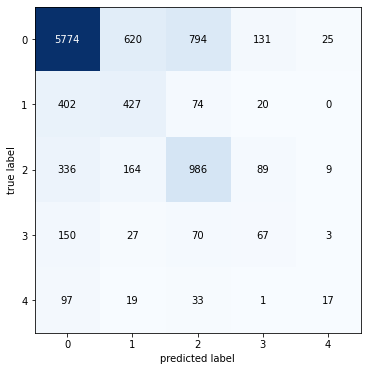

In [159]:
import seaborn as sns
sns.heatmap(matrice, annot=True)


In [170]:
num_classes=5
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_valid_raw, y_pred, target_names=target_names))

   precision  recall  f1-score
0       0.78    0.85      0.81
1       0.46    0.34      0.39
2       0.62    0.50      0.56
3       0.21    0.22      0.21
4       0.10    0.31      0.15


## sauvegarde du modele Resnet50

In [63]:
from keras.models import load_model 
model.save("Resnet5070.h5") 


## chargement du modéle 

In [64]:
loaded_model = load_model("Resnet5070.h5") 


## Test

In [68]:
x_test = []

In [72]:
path = 'D:/test/test/'
images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.jpeg']
lst = map(lambda each:each.strip(".jpeg"), images)
test = pd.DataFrame(lst,columns =['image']) 
test.head()
test.reset_index(drop=True, inplace=True)

In [73]:
test.to_csv('test.csv')

In [131]:
len(x_test)

2938

In [76]:
import numpy as np
from keras.preprocessing import image

In [99]:
model77 = load_model("Resnet5070.h5")


model77.summary()
model77.predict(x_valid_raw)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [100]:
dd = model77.predict(x_valid_raw)

## CHARGEMENT DE 55730 images de test

In [130]:
import glob

i=0
for img in glob.glob("D:/test/test/*.jpeg"):
    try:
        img = image.load_img(img, target_size=(256,256))
        arr = image.img_to_array(img)
        x_test.append(arr)
        i += 1 
    except:
        pass

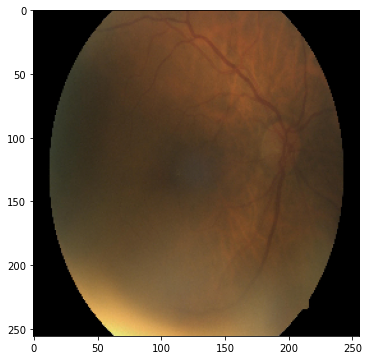

In [133]:
plt.imshow(x_test[99]/255)
plt.show()

In [135]:
x_test_raw = np.array(x_test)


In [139]:
prediction_test = model77.predict(x_test_raw)

In [141]:
prediction_test = np.argmax(np.round(prediction_test),axis=1)


In [145]:
results = pd.DataFrame({'image': pd.Series(test['image']), 'level': pd.Series(prediction_test)})
results.to_csv('results-DR-MOUKRIME-DKAKI.csv', index=False)



In [ ]:
#csv_train = pd.read_csv('trainLabels.csv') #lecture des label


In [191]:
results['level'].value_counts()

0    47394
1     3762
2     1214
3     1206
Name: level, dtype: int64

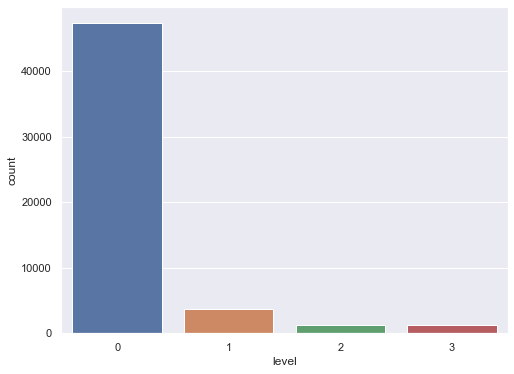

In [192]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="level", data=results)